We will create a recommendation system with Python using pandas and SciPy. We have used famous MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. It contains 100k movie ratings from 943 users and a selection of 1682 movies.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

Two most common types of recommender systems are *Content-Based* and *Collaborative Filtering (CF)*. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In general, **Collaborative filtering (CF)** is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 
Here we implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity. 
- Memory-based models are based on similarity between items or users, where we use cosine-similarity.
- Model-based CF is based on matrix factorization where we use SVD to factorize the matrix.

In this notebook, we create two types of recommender systems:
1. a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. This is not a true robust recommendation system, to describe it more accurately,it just tells what movies/items are most similar to your movie choice.
2. Memory-Based Collaborative Filtering(*user-item filtering* and *item-item filtering*) and Model-Based Collaborative filtering models

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('u.data',sep='\t',names=['user_id','item_id','rating','timestamp'])

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [4]:
movie_titles = pd.read_csv('Movie_Id_Titles')

In [5]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
user_id      100003 non-null int64
item_id      100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
title        100003 non-null object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


In [8]:
df.describe()

,user_id,item_id,rating,timestamp
count,100003.000000,100003.000000,100003.000000,1.000030e+05
mean,462.470876,425.520914,3.529864,8.835288e+08
std,266.622454,330.797791,1.125704,5.343791e+06
min,0.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


# EDA
Let's explore the data a bit and get a look at some of the best rated movies.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [10]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [11]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [12]:
ratings_df['number of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_df.head()

,rating,number of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


(array([ 69.,   0.,   1.,   3.,   3.,   1.,  11.,   4.,   9.,   5.,  14.,
          8.,  53.,   6.,  22.,  31.,  27.,  35.,  59.,  26.,  52.,  58.,
         54.,  42.,  27., 139.,  70.,  77.,  64.,  60.,  76.,  71.,  62.,
         69.,  62.,  58.,  47.,  74.,  36.,  25.,  19.,  12.,   2.,  10.,
          0.,   1.,   0.,   0.,   0.,  10.]),
 array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ,
        1.88, 1.96, 2.04, 2.12, 2.2 , 2.28, 2.36, 2.44, 2.52, 2.6 , 2.68,
        2.76, 2.84, 2.92, 3.  , 3.08, 3.16, 3.24, 3.32, 3.4 , 3.48, 3.56,
        3.64, 3.72, 3.8 , 3.88, 3.96, 4.04, 4.12, 4.2 , 4.28, 4.36, 4.44,
        4.52, 4.6 , 4.68, 4.76, 4.84, 4.92, 5.  ]),
 <a list of 50 Patch objects>)

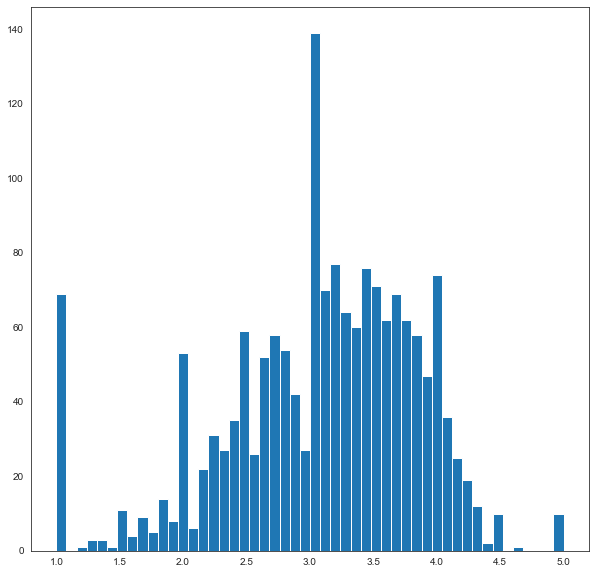

In [13]:
plt.figure(figsize=(10,10))
plt.hist(ratings_df['rating'],bins=50)

(array([601., 198., 123., 120.,  83.,  77.,  60.,  49.,  37.,  30.,  44.,
         22.,  21.,  23.,  26.,  19.,  13.,  12.,  17.,   8.,  10.,  10.,
          7.,   6.,   4.,  13.,   1.,   5.,   2.,   3.,   0.,   2.,   3.,
          3.,   0.,   2.,   2.,   0.,   1.,   0.,   1.,   2.,   0.,   3.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  12.66,  24.32,  35.98,  47.64,  59.3 ,  70.96,  82.62,
         94.28, 105.94, 117.6 , 129.26, 140.92, 152.58, 164.24, 175.9 ,
        187.56, 199.22, 210.88, 222.54, 234.2 , 245.86, 257.52, 269.18,
        280.84, 292.5 , 304.16, 315.82, 327.48, 339.14, 350.8 , 362.46,
        374.12, 385.78, 397.44, 409.1 , 420.76, 432.42, 444.08, 455.74,
        467.4 , 479.06, 490.72, 502.38, 514.04, 525.7 , 537.36, 549.02,
        560.68, 572.34, 584.  ]),
 <a list of 50 Patch objects>)

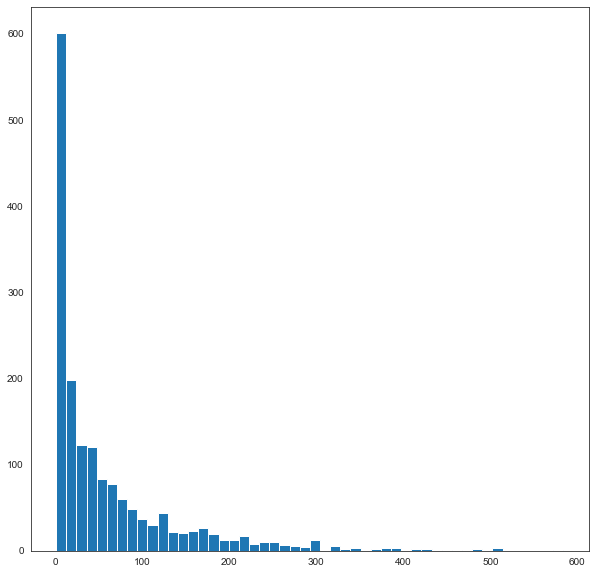

In [14]:
plt.figure(figsize=(10,10))
plt.hist(ratings_df['number of ratings'],bins=50)

<Figure size 720x720 with 0 Axes>

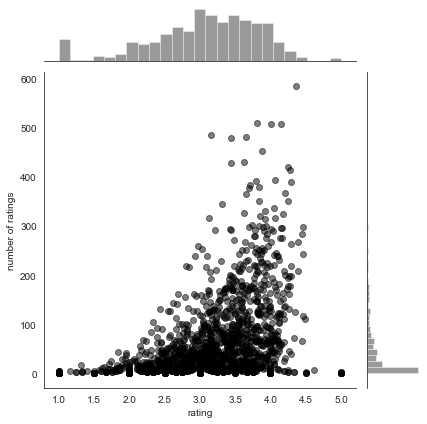

In [15]:
plt.figure(figsize=(10,10))
sns.jointplot(ratings_df['rating'],ratings_df['number of ratings'],alpha=0.5,color='black')

# A simple recommendation system recommending Similar Movies

In [16]:
movie_mat = df.pivot_table(index='user_id',columns='title',values='rating')

In [17]:
movie_mat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of NaN values, because most people have not seen most of the movies.

Most rated movie:

In [18]:
ratings_df.sort_values('number of ratings',ascending=False).head(10)

,rating,number of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


So we select Star Wars and Liar Liar (different genres)

In [19]:
starwars_ratings = movie_mat['Star Wars (1977)']
liarliar_ratings = movie_mat['Liar Liar (1997)']


In [20]:
starwars_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [21]:
liarliar_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

Finding correlations for getting similar movies as them (using ratings)

In [22]:
similar_to_starwars = movie_mat.corrwith(starwars_ratings)
similar_to_liarliar = movie_mat.corrwith(liarliar_ratings)

/Users/rajkumar/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/rajkumar/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Creating a dataframe from this series

In [23]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [24]:
corr_starwars = corr_starwars.join(ratings_df['number of ratings'])
corr_starwars.head()

,Correlation,number of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Sort the dataframe by correlation to get the most similar movies.Some results won't really make sense because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie).

In [25]:
corr_starwars.sort_values('Correlation',ascending=False).head()

,Correlation,number of ratings
title,,
Man of the Year (1995),1.0,9
Hollow Reed (1996),1.0,6
Stripes (1981),1.0,5
"Beans of Egypt, Maine, The (1994)",1.0,2
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0,5


In [26]:
corr_starwars.sort_values('number of ratings',ascending=False).head()

,Correlation,number of ratings
title,,
Star Wars (1977),1.000000,584
Contact (1997),0.134962,509
Fargo (1996),0.044415,508
Return of the Jedi (1983),0.672556,507
Liar Liar (1997),0.150292,485


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based on the histogram from earlier). The results make a lot more sense:

In [27]:
corr_starwars[corr_starwars['number of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,number of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now the same for the comedy Liar Liar:

In [28]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [29]:
corr_liarliar=corr_liarliar.join(ratings_df['number of ratings'])
corr_liarliar.head()

,Correlation,number of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [30]:
corr_liarliar.sort_values('Correlation',ascending=False).head()


,Correlation,number of ratings
title,,
For Ever Mozart (1996),1.0,3
Mina Tannenbaum (1994),1.0,6
Of Human Bondage (1934),1.0,5
Love and Death on Long Island (1997),1.0,2
Johnny 100 Pesos (1993),1.0,2


In [31]:
corr_liarliar[corr_liarliar['number of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,number of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


# Collaborative Filtering models

Number of unique users and movies:

In [32]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_data,test_data = train_test_split(df,test_size=0.25)

In [35]:
train_data.head()

,user_id,item_id,rating,timestamp,title
29261,148,408,5,877399018,"Close Shave, A (1995)"
17014,682,685,3,888522541,Executive Decision (1996)
84296,450,457,2,882466909,Free Willy 3: The Rescue (1997)
82245,727,470,5,883711847,Tombstone (1993)
87291,303,123,4,879468149,"Frighteners, The (1996)"


## Memory Based CF
Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**.

A *user-item filtering* take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked.

In contrast, *item-item filtering* take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

- Item-Item Collaborative Filtering: “Users who liked this item also liked …”
- User-Item Collaborative Filtering: “Users who are similar to you also liked …”

In both cases, create a user-item matrix which built from the entire dataset.

In [36]:
train_data_matrix = np.zeros((n_users,n_items))

In each line (iterator) of itertuples below, we have the data of the index in that dataframe. Here index start from 1
line[1] is user_id
line[2] is item_id
line[3] is rating
and when setting the rating ,we do -1 in the index to start the index from 0 in the resulting matrix i.e. train_data_matrix and test_data_matrix

In [37]:
# Example
for line in train_data.head().itertuples():
    print(line[3])

5
3
2
5
4


Create two user-item matrices, one for training and another for testing

In [38]:

for line in train_data.itertuples():
    train_data_matrix[line[1]-1,line[2]-1] = line[3]

In [39]:
train_data_matrix.shape

(944, 1682)

In [40]:
train_data_matrix[:6,:6]

array([[5., 3., 4., 3., 3., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [41]:
df[df['user_id']==1]

,user_id,item_id,rating,timestamp,title
257,1,50,5,874965954,Star Wars (1977)
926,1,172,5,874965478,"Empire Strikes Back, The (1980)"
999,1,133,4,876892818,Gone with the Wind (1939)
1138,1,242,5,889751633,Kolya (1996)
1557,1,51,4,878543275,Legends of the Fall (1994)
1956,1,265,4,878542441,"Hunt for Red October, The (1990)"
2460,1,86,5,878543541,"Remains of the Day, The (1993)"
2697,1,257,4,874965954,Men in Black (1997)
2992,1,222,4,878873388,Star Trek: First Contact (1996)
3369,1,40,3,876893230,"To Wong Foo, Thanks for Everything! Julie Newm..."


In [42]:
test_data_matrix = np.zeros((n_users,n_items))

In [43]:
for line in test_data.itertuples():
    test_data_matrix[line[1]-1,line[2]-1] = line[3]

In [44]:
train_data[train_data['user_id']==0]

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
952,0,133,1,881250949,Gone with the Wind (1939)
584,0,172,5,881250949,"Empire Strikes Back, The (1980)"


In [45]:
train_data_matrix[-1][132]

1.0

Using Pairwise distance amongst each matrix to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

In [46]:
from sklearn.metrics.pairwise import pairwise_distances

In [47]:
user_similarity = pairwise_distances(train_data_matrix,metric='cosine')

In [48]:
item_similarity = pairwise_distances(train_data_matrix.T,metric='cosine')

In [49]:
user_similarity[:6,:6]

array([[0.        , 0.85208504, 0.95743712, 0.95472266, 0.66998509,
        0.6562318 ],
       [0.85208504, 0.        , 0.94486586, 0.79835074, 0.95513699,
        0.81628574],
       [0.95743712, 0.94486586, 0.        , 0.83619601, 0.97321978,
        0.92688992],
       [0.95472266, 0.79835074, 0.83619601, 0.        , 0.96193203,
        0.94806312],
       [0.66998509, 0.95513699, 0.97321978, 0.96193203, 0.        ,
        0.79712994],
       [0.6562318 , 0.81628574, 0.92688992, 0.94806312, 0.79712994,
        0.        ]])

In [50]:
item_similarity[:6,:6]

array([[0.        , 0.69657445, 0.74784415, 0.65577726, 0.78889218,
        0.92688338],
       [0.69657445, 0.        , 0.78932456, 0.67280434, 0.80124093,
        0.95573282],
       [0.74784415, 0.78932456, 0.        , 0.75434384, 0.84521703,
        0.95628434],
       [0.65577726, 0.67280434, 0.75434384, 0.        , 0.76990462,
        0.90899521],
       [0.78889218, 0.80124093, 0.84521703, 0.76990462, 0.        ,
        1.        ],
       [0.92688338, 0.95573282, 0.95628434, 0.90899521, 1.        ,
        0.        ]])

In [51]:
def predict(ratings,similarity,type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:,np.newaxis])
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff)/np.array([np.abs(similarity).sum(axis=1)]).T
    elif type== 'item':
        pred = ratings.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [52]:
user_prediction = predict(train_data_matrix,user_similarity,type='user')
item_prediction = predict(train_data_matrix,item_similarity,type='item')

In [53]:
user_prediction

array([[ 1.58006997,  0.5646033 ,  0.49122088, ...,  0.29721646,
         0.29470992,  0.29470992],
       [ 1.31196959,  0.2474428 ,  0.14002507, ..., -0.08348227,
        -0.08526156, -0.08526156],
       [ 1.32231458,  0.2279769 ,  0.12695603, ..., -0.09818764,
        -0.09982035, -0.09982035],
       ...,
       [ 1.35393972,  0.29316629,  0.21203154, ..., -0.00789189,
        -0.00998906, -0.00998906],
       [ 1.41409308,  0.37455223,  0.31051183, ...,  0.11493542,
         0.11243448,  0.11243448],
       [ 1.19795511,  0.15222283,  0.06360419, ..., -0.15646192,
        -0.15874663, -0.15874663]])

In [54]:
item_prediction

array([[0.36987854, 0.39101034, 0.40157443, ..., 0.44925442, 0.44675788,
        0.44675788],
       [0.07135395, 0.08176785, 0.07967538, ..., 0.08228533, 0.08387864,
        0.08387864],
       [0.06666588, 0.06982351, 0.06853175, ..., 0.06661923, 0.06960143,
        0.06960143],
       ...,
       [0.12616888, 0.13634583, 0.1436685 , ..., 0.15003672, 0.15050565,
        0.15050565],
       [0.21368323, 0.21461902, 0.23428624, ..., 0.26725366, 0.26531826,
        0.26531826],
       [0.00389934, 0.00495023, 0.00567006, ..., 0.00659146, 0.00654372,
        0.00654372]])

In [55]:
from sklearn.metrics import mean_squared_error

In [56]:
from math import sqrt

In [57]:
def rmse(predictions,testdata):
    predictions = predictions[testdata.nonzero()].flatten()
    testdata = testdata[testdata.nonzero()].flatten()
    return sqrt(mean_squared_error(predictions,testdata))
    

In [58]:
print('User base RMSE : '+str(rmse(user_prediction,test_data_matrix)))

User base RMSE : 3.12206911670384


In [59]:
print('Item base RMSE : '+str(rmse(item_prediction,test_data_matrix)))

Item base RMSE : 3.4508606076399317


Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system.

# Model Based CF

Model-based Collaborative Filtering is based on matrix factorization (MF).The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization we can restructure the user-item matrix into low-rank structure, and we can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. 

In [60]:
# To calculate sparsity of a matrix:
round(1 - len(df)/float(n_users*n_items),3)

0.937

The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.


Now you can make a prediction by taking dot product of *`U`*, *`S`* and *`V^T`*.

In [61]:
from scipy.sparse.linalg import svds

In [62]:
#get SVD components from train matrix. Choose k.
u, s ,vt = svds(train_data_matrix,k=20)

In [63]:
s_diag_mat = np.diag(s)

In [64]:
x_pred = np.dot(np.dot(u,s_diag_mat),vt)

In [65]:
print('User-based CF MSE: ' + str(rmse(x_pred, test_data_matrix)))

User-based CF MSE: 2.7097399598167695


To give an example of the learned latent preferences of the users and items: let's say for the MovieLens dataset we have the following information: *(user id, age, location, gender, movie id, director, actor, language, year, rating)*. By applying matrix factorization the model learns that important user features are *age group (under 10, 10-18, 18-30, 30-90)_, _location and gender_*, and for movie features it learns that *_decade_, _director and actor* are most important. Now if you look into the information you have stored, there is no such feature as the *_decade_*, but the model can learn on its own. The important aspect is that the CF model only uses data (user_id, movie_id, rating) to learn the latent features. If there is little data available model-based CF model will predict poorly, since it will be more difficult to learn the latent features.